### Run these code cells in the following order to generate the police patrol allocation advice

In [61]:
### Libraries
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import os
import numpy as np
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
import networkx as nx
from shapely.geometry import MultiLineString
from collections import defaultdict
import random
from shapely import wkt



Get all of the data:
- Police (burglary) data (already in the repo, should be retrieved by the API eventually)

- Datasets (these are already uploaded in the repository)

- LSOA boundary data (download 'Contains LSOA 2021 boundaries grouped by Boroughs' from https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london)

- LSOA to ward mapping data (download the csv file from: https://geoportal.statistics.gov.uk/datasets/lsoa-2021-to-electoral-ward-2024-to-lad-2024-best-fit-lookup-in-ew/about)

- UK road data (download GeoPackage file from: https://www.data.gov.uk/dataset/65bf62c8-eae0-4475-9c16-a2e81afcbdb0/os-open-roads1)



Transform the data

In [62]:
### Create the merged burglary data csv file

# Set your path to the folder containing all monthly subfolders
base_path = Path("UK_police_data")  # CHANGE THIS to your path
output_path = base_path / "all_burglary_data.csv"

if output_path.exists():
    print(f"File already exists: {output_path}. Skipping merge.")
else:
    all_data = []

    # Loop through all year-month folders
    for folder in sorted(base_path.glob("20[2-3][0-9]-*")):
        month = folder.name
        # Look for files ending with "-street.csv"
        street_files = list(folder.glob("*-street.csv"))
        
        for file in street_files:
            try:
                df = pd.read_csv(file)
                df["Month"] = month
                df["Source file"] = file.name
                all_data.append(df)
            except Exception as e:
                print(f"Failed to read {file.name}: {e}")

    # Combine all data
    merged_df = pd.concat(all_data, ignore_index=True)

    # Save merged data
    merged_df.to_csv(output_path, index=False)
    print(f"Merged dataset saved to: {output_path}")

File already exists: UK_police_data\all_burglary_data.csv. Skipping merge.


In [63]:
### Create the road file for only the london roads (speeds things up enormously)
### (The large uk roads file is no longer needed after this)

def save_london_roads(path_to_uk_road_file):
    output_path =  Path("datasets/london_road_links_only.gpkg")
    if output_path.exists():
        print(output_path, 'already exists, code skipped.')
    else:
        # Rough bounding box for Greater London (WGS84 coordinates)
        london_bbox = box(-0.5103, 51.2868, 0.3340, 51.6919)  # (minx, miny, maxx, maxy)

        # Convert to GeoDataFrame
        bbox_gdf = gpd.GeoDataFrame({'geometry': [london_bbox]}, crs="EPSG:4326")

        print("Reading road links...")
        road_links = gpd.read_file("datasets/uk_road.gpkg", layer="road_link")
        print("Done reading. Reprojecting...")

        road_links = road_links.to_crs("EPSG:4326")
        print("Done reprojecting. Clipping to London...")

        london_roads = gpd.clip(road_links, bbox_gdf)
        print("Clipping done.")

        london_roads.to_file(output_path, layer="road_node", driver="GPKG")

save_london_roads('datasets/uk_road.gpkg') # Change path to whatever your road data Geopackage file is called

datasets\london_road_links_only.gpkg already exists, code skipped.


In [64]:
### Add roads to LSOAs

def get_lsoa_geodata(lsoa_folder: str) -> gpd.GeoDataFrame:
    # Folder where you downloaded all borough LSOA files
    folder_path = lsoa_folder

    print("Getting lsoa geodata...")

    # List all files (e.g. all shapefiles or GeoJSONs)
    files = [f for f in os.listdir(folder_path) if f.endswith('.shp')]  # or '.shp'

    # Read and concatenate all files
    lsoa_list = []
    for file in files:
        gdf = gpd.read_file(os.path.join(folder_path, file))
        lsoa_list.append(gdf)

    # Combine into one GeoDataFrame
    lsoa_all = gpd.GeoDataFrame(pd.concat(lsoa_list, ignore_index=True))

    return lsoa_all

lsoa_data = get_lsoa_geodata("datasets/lsoa_boundaries") # Change to the path to your lsoa_boundaries folder

london_roads = gpd.read_file('datasets/london_road_links_only.gpkg') # Path should be this, since it was generated by a previous cell

london_roads = london_roads.to_crs(lsoa_data.crs) # make sure its in the same format

roads_with_lsoa = gpd.sjoin(london_roads, lsoa_data, how="left", predicate="intersects")


Getting lsoa geodata...


Calculate the predicted burglary (risks)

In [65]:
### Generate risk data file

# 1. Load burglary data and aggregate per LSOA per month
df = pd.read_csv("UK_police_data/all_burglary_data.csv")
df["Month"] = pd.to_datetime(df["Month"], format="%Y-%m").dt.to_period("M").astype(str)

df_burglary = df[df["Crime type"] == "Burglary"]
burglary_counts = (
    df_burglary
    .groupby(["LSOA name", "Month"])
    .size()
    .reset_index(name="Burglary Count")
    .sort_values(by=["Month", "Burglary Count"], ascending=[True, False])
)

burglary_counts.to_csv("burglary_risk_by_ward.csv", index=False)
print("Burglary risk per LSOA ward per month saved to 'burglary_risk_by_ward.csv'.")

# 2. Load IMD data and merge with burglary data
risk_df = pd.read_csv("burglary_risk_by_ward.csv")
imd_df = pd.read_csv("merged_lsoa_crime_data.csv")
risk_df.rename(columns={"LSOA name": "LSOA"}, inplace=True)
imd_df.rename(columns={"LSOA name (2011)": "LSOA"}, inplace=True)

data = risk_df.merge(imd_df, on="LSOA", how="left", validate="many_to_one").dropna(subset=["Burglary Count"])

# 3. time/seasonality features
data["Month"] = pd.to_datetime(data["Month"])
data["Month_Period"] = data["Month"].dt.to_period("M")
min_period = data["Month_Period"].min()
data["month_num"] = (data["Month_Period"] - min_period).apply(lambda x: x.n)
data["sin12"] = np.sin(2 * np.pi * data["month_num"] / 12)
data["cos12"] = np.cos(2 * np.pi * data["month_num"] / 12)

# 4. regression model 
X_cols = {
    "Income Score (rate)": "x1",
    "Employment Score (rate)": "x2",
    "Education, Skills and Training Score": "x3",
    "Health Deprivation and Disability Score": "x4",
    "Barriers to Housing and Services Score": "x5",
    "Living Environment Score": "x6",
    "Children and Young People Sub-domain Score": "x7",
    "Adult Skills Sub-domain Score": "x8",
    "Wider Barriers Sub-domain Score": "x9",
    "Indoors Sub-domain Score": "x10",
    "Outdoors Sub-domain Score": "x11",
}
X_use = {csv: alias for csv, alias in X_cols.items() if csv in data.columns}

X = data[list(X_use.keys()) + ["month_num", "sin12", "cos12"]]
X = sm.add_constant(X)
y = data["Burglary Count"]
combined = pd.concat([X, y], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
X = combined.drop("Burglary Count", axis=1)
y = combined["Burglary Count"]

model = sm.OLS(y, X).fit()
print(model.summary())

# 5. forecast for each calendar month across years 
imd_df = pd.read_csv("merged_lsoa_crime_data.csv")
imd_df.rename(columns={"LSOA name (2011)": "LSOA"}, inplace=True)
X_use_list = list(X_use.keys())

ref_month = pd.to_datetime("2022-03")  
forecast_months = [f"Month-{i+1:02d}" for i in range(12)]  # Month-01 to Month-12
forecast_results = []

for i in range(12):
    target_month = pd.to_datetime(f"2025-{i+1:02d}")
    month_num = ((target_month.to_period("M") - ref_month.to_period("M")).n)
    sin12 = np.sin(2 * np.pi * month_num / 12)
    cos12 = np.cos(2 * np.pi * month_num / 12)

    pred_df = imd_df[["LSOA"] + X_use_list].copy()
    pred_df["month_num"] = month_num
    pred_df["sin12"] = sin12
    pred_df["cos12"] = cos12
    pred_df["Month"] = forecast_months[i]

    X_pred = sm.add_constant(pred_df[X_use_list + ["month_num", "sin12", "cos12"]], has_constant="add")
    pred_df["Predicted Burglary Count"] = model.predict(X_pred)
    forecast_results.append(pred_df)

full_forecast = pd.concat(forecast_results, ignore_index=True)

# mormalize within each calendar month
full_forecast["Risk %"] = (
    full_forecast.groupby("Month")["Predicted Burglary Count"]
    .transform(lambda x: 100 * (x - x.min()) / (x.max() - x.min()))
)

full_forecast.to_csv("burglary_risk_forecast_all_months.csv", index=False)
print("Forecast for every calendar month saved to 'burglary_risk_forecast_all_months.csv'.")

# example for January
print("\n Top 5 most at-risk LSOAs in January:")
print(full_forecast[full_forecast["Month"] == "Month-01"]
      .sort_values("Risk %", ascending=False)[["LSOA", "Predicted Burglary Count", "Risk %"]].head(5))


Burglary risk per LSOA ward per month saved to 'burglary_risk_by_ward.csv'.
                            OLS Regression Results                            
Dep. Variable:         Burglary Count   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     351.0
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:59:41   Log-Likelihood:            -1.3796e+05
No. Observations:               82017   AIC:                         2.759e+05
Df Residuals:                   82002   BIC:                         2.761e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

Add the wards and roads to the data

In [66]:
### Add wards to the data

def add_wards_to_data(lsoa_to_ward_path: str, data_df_path: str = 'burglary_risk_forecast_all_months.csv', new_file_name: str = 'burglary_risk_forecast_all_months_incl_wards.csv') -> None:
    if Path(new_file_name).exists():
        print(new_file_name, 'already exists, skipping code')
    else:
        # Get the data
        df_main = pd.read_csv(data_df_path)
        df_lookup = pd.read_csv(lsoa_to_ward_path)

        # Merge the data on LSOA's
        df_merged: pd.DataFrame = df_main.merge(
        df_lookup[['LSOA21NM', 'WD24CD', 'WD24NM']],
        left_on='LSOA name (2011)',
        right_on='LSOA21NM',
        how='left'
        )

        # Get rid of the double LSOA column since it is no longer needed
        df_merged = df_merged.drop(columns=['LSOA21NM'])
        
        print(df_merged.head())

        df_merged.to_csv(new_file_name, index=False)
        print('Created new data file named: ', new_file_name)

add_wards_to_data('datasets/LSOA_(2021)_to_Electoral_Ward_(2024)_to_LAD_(2024).csv') # Change this to your path

burglary_risk_forecast_all_months_incl_wards.csv already exists, skipping code


In [67]:
### Add roads to the data

roads_with_lsoa = roads_with_lsoa.rename(columns={"lsoa21nm": "LSOA"})

grouped_roads = roads_with_lsoa.dissolve(by='LSOA', as_index=False)

risk_data = pd.read_csv("burglary_risk_forecast_all_months_incl_wards.csv")
grouped_roads = grouped_roads.merge(risk_data, on='LSOA', how='left')

grouped_roads.to_csv('final_forecast.csv', index=False)

Select the month and ward you want to allocate

In [68]:
selected_month = 'Month-12' ### Choose how many months in the future you want to do

ward_to_divide = "Regent's Park" ### Choose the ward

df = pd.read_csv('final_forecast.csv')

df = df[df['Month'] == selected_month]
df = df[df['WD24NM'] == ward_to_divide].copy()

df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry', crs=london_roads.crs)

print(df.head())

              LSOA                                           geometry  \
10938  Camden 021B  MULTILINESTRING ((528933.08 182193.51, 528948....   
10950  Camden 021C  MULTILINESTRING ((529172.9 183086.07, 529169.9...   
10962  Camden 021D  MULTILINESTRING ((528348.26 183583.44, 528328....   
11024  Camden 023A  MULTILINESTRING ((528908 182272, 528913.42 182...   
11036  Camden 023C  MULTILINESTRING ((528906.25 182759.13, 528896....   

                                         id  fictitious road_classification  \
10938  6B65DBE3-12EC-4D54-8116-D06E531522BF       False        Unclassified   
10950  78891FA1-9214-4D35-8AFE-DC3F9F602C0F       False        Unclassified   
10962  8B92057E-6BEA-4079-A4AA-19CC40A4D996       False      Not Classified   
11024  5A38D9DE-1668-4388-BFA0-773A11AAEB69       False        Unclassified   
11036  D7894A89-497F-4052-92EA-C6EE5FCF8099       False        Unclassified   

                      road_function         form_of_way  \
10938                    Mi

Generate the patrol allocation

In [69]:
### Method definitions for generating patrol districts

def generate_graph(df) -> nx.Graph:
    """
    Given a Dataframe with LSOA's and the roads within, generates a graph with LSOA's as nodes with edges between touching LSOA's. 
    """
    # Clean up the GeoDataFrame
    gdf = df.copy().reset_index(drop=True)

    # Drop conflicting columns if they exist
    for col in ['index_right', 'index1']:
        if col in gdf.columns:
            gdf = gdf.drop(columns=[col])

    # Add custom ID for spatial join tracking
    gdf['index1'] = gdf.index
    gdf['LSOA'] = gdf['LSOA']

    gdf['geometry_buffered'] = gdf.geometry.buffer(10)  # buffer by 10 meters

    #print('Generating neighbours...')
    # Run spatial join
    neighbors = gpd.sjoin(
        gdf.set_geometry('geometry_buffered'), 
        gdf.set_geometry('geometry_buffered'), 
        how="inner", predicate="intersects"
    )

    # Remove self-joins
    neighbors = neighbors[neighbors['index1_left'] != neighbors['index1_right']]

    # Build graph
    G = nx.Graph()

    #print('Generating graph...')
    for _, row in gdf.iterrows():
        G.add_node(row['LSOA'], workload=row['Predicted Burglary Count'])

    for _, row in neighbors.iterrows():
        try:
            node1 = row['LSOA_left']
            node2 = row['LSOA_right']
            G.add_edge(node1, node2)
        except Exception as e:
            print(f"Edge creation failed: {e}")

    return G


def region_growing_partition(df, G, k):
    """
    Takes in our data and a graph G made from the LSOA's and an integer k, and divides the area into k patrol districts balanced by workload. 
    """

    total_workload = df['Predicted Burglary Count'].sum()
    target_workload = total_workload / k
    assigned = set()
    districts = defaultdict(list)
    district_workload = defaultdict(float)
    
    # Select the top-k highest workload LSOAs as seeds
    seed_lsoas = df.sort_values('Predicted Burglary Count', ascending=False)['LSOA'].tolist()[:k]
    for i, seed in enumerate(seed_lsoas):
        districts[i].append(seed)
        district_workload[i] += G.nodes[seed]['workload']
        assigned.add(seed)

    # Grow each region
    frontier = {i: set(G.neighbors(seed)) - assigned for i, seed in enumerate(seed_lsoas)}

    changed = True
    while changed:
        changed = False
        for i in range(k):
            # Prioritize frontier nodes by lowest workload
            candidates = list(frontier[i])
            candidates.sort(key=lambda lsoa: G.nodes[lsoa]['workload'])

            for candidate in candidates:
                if candidate in assigned:
                    continue
                if district_workload[i] + G.nodes[candidate]['workload'] > target_workload * 1.1:
                    continue

                # Assign and update
                districts[i].append(candidate)
                district_workload[i] += G.nodes[candidate]['workload']
                assigned.add(candidate)
                changed = True

                # Add new neighbors to frontier
                for neighbor in G.neighbors(candidate):
                    if neighbor not in assigned:
                        frontier[i].add(neighbor)

                frontier[i].remove(candidate)
                break  # move to next district to ensure fairness

    for district_id, nodes in districts.items():
        total_workload = sum(df.loc[df['LSOA'].isin(nodes), 'Predicted Burglary Count'])

    return districts


def divide_workload(df):
    # Step 1: Get workload per district
    workload = df.groupby('patrol_district')['Predicted Burglary Count'].sum()

    # Step 2: Calculate proportional officer allocation
    total_officers = 100
    proportions = workload / workload.sum()
    officer_assignment = (proportions * total_officers).round().astype(int)

    # Step 3: Optional adjustment for rounding error
    difference = total_officers - officer_assignment.sum()
    if difference != 0:
        adjust = officer_assignment.sort_values(ascending=(difference < 0)).index[:abs(difference)]
        officer_assignment.loc[adjust] += int(difference / abs(difference))

    print("Officers per patrol district:")
    print(officer_assignment)


def find_optimal_k(df, G, ward_name: str, plot_k_values: bool = False):
    max_k = df['LSOA'].nunique()

    # If the ward only contains 1 LSOA we can return early as there is only one way to divide
    if max_k <= 1:
        return 1

    district_counts = range(2, max_k + 1)
    stds = []

    for k in district_counts:
        districts = region_growing_partition(df, G, k)

        # Assign back to GeoDataFrame
        district_map = {lsoa: i for i, group in districts.items() for lsoa in group}
        df['patrol_district'] = df['LSOA'].map(district_map)

        workloads = df.groupby('patrol_district')['Predicted Burglary Count'].sum()
        stds.append(workloads.std() / workloads.mean())

    optimal_k = stds.index(min(stds)) + 2 # Finds the k value, starting at 2, with the lowest std value

    if plot_k_values:
        plt.plot(district_counts, stds, marker='o')
        plt.xlabel("Number of Districts")
        plt.ylabel("Workload Coefficient of Variation")
        plt.title("Elbow Method for Optimal Patrol Districts")
        plt.show()

    return optimal_k

In [70]:
### Generate districts

# Build graph
G = generate_graph(df)
print("Number of connected components (buffered):", nx.number_connected_components(G))

degrees = [d for n, d in G.degree()]
print("Average degree:", sum(degrees)/len(degrees))

# Find the optimal number of patrol districts
k = find_optimal_k(df, G, ward_to_divide)

# Run partitioning
districts = region_growing_partition(df, G, k)

# Assign back to GeoDataFrame
district_map = {lsoa: i for i, group in districts.items() for lsoa in group}
df['patrol_district'] = df['LSOA'].map(district_map)

divide_workload(df)

Number of connected components (buffered): 1
Average degree: 3.5714285714285716
Officers per patrol district:
patrol_district
0.0    14
1.0    12
2.0    11
3.0    11
4.0    11
5.0    11
6.0    10
7.0    10
8.0    10
Name: Predicted Burglary Count, dtype: int32


Plotting patrol districts


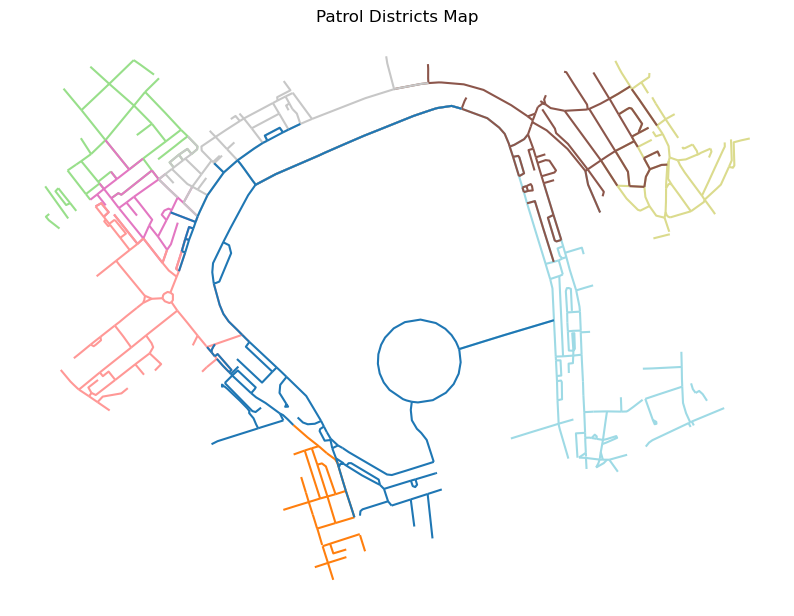

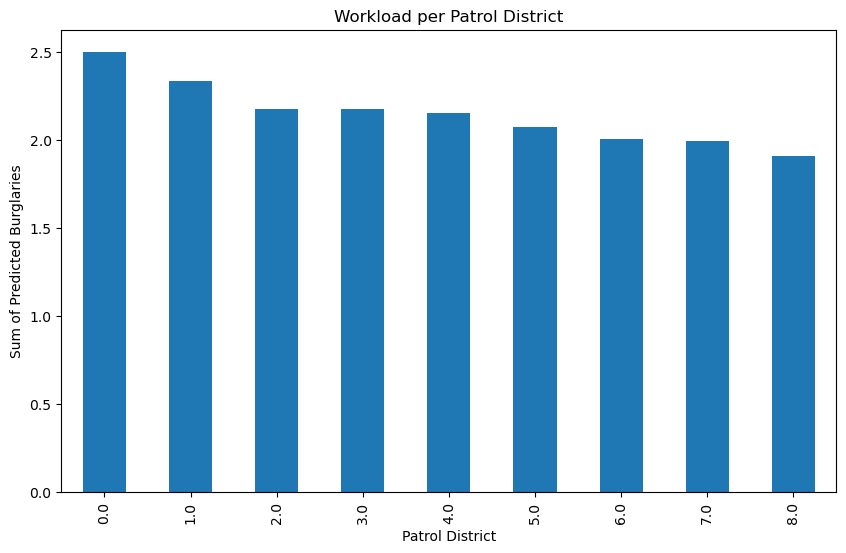

In [ ]:
print('Plotting patrol districts')
fig, ax = plt.subplots(figsize=(10, 10))

# # Plot LSOA polygons (background) (this zooms out the map to the entirety of london)
# lsoa_data.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.5)

# Plot patrol districts
df.plot(ax=ax, column='patrol_district', cmap='tab20', legend=False, figsize=(10, 10))
plt.title('Patrol Districts Map')
plt.axis('off')  # Optional: remove axis ticks for cleaner map
plt.show()

# Plot workload bar chart
df.groupby('patrol_district')['Predicted Burglary Count'].sum().plot(
    kind='bar', title='Workload per Patrol District', figsize=(10, 6))
plt.xlabel('Patrol District')
plt.ylabel('Sum of Predicted Burglaries')
plt.show()